## Airbnb Prices - Machine Learning

In [261]:
# requiered packages for modelling
!{sys.executable} -m pip install xgboost

'{sys.executable}' is not recognized as an internal or external command,
operable program or batch file.


In [430]:
#Standard Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time as time

#Modelling Imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [431]:
#Import listings csv
final_df = pd.read_csv('Resources/listings_cleaned.csv')

C:\Users\empha\anaconda3\envs\PythonData1\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (46,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [432]:
final_df.head()

,id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,property_type,room_type,...,white_goods,elevator,gym,parking,host_greeting,internet,long_term_stays,private_entrance,time_since_first_review,time_since_last_review
0,35797,2010-06-28,unknown,unknown,0.0,2.0,1.0,Cuajimalpa de Morelos,House,Entire home/apt,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN
1,44616,2010-08-09,within a day,50-89%,0.0,9.0,1.0,Cuauhtémoc,House,Entire home/apt,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN
2,56074,2010-10-19,within an hour,100%,1.0,2.0,1.0,Cuauhtémoc,House,Entire home/apt,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,4+ years,2-8 weeks
3,58955,2010-11-09,within a few hours,100%,0.0,1.0,1.0,Cuauhtémoc,Apartment,Entire home/apt,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1-2 years,NaN
4,61792,2010-11-26,within an hour,100%,0.0,1.0,1.0,Cuauhtémoc,House,Private room,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1-2 years,2-8 weeks


In [455]:
final_df['price'].head(10)

0     3979
1    13000
2      379
3     1532
4     1194
5     1890
6     1094
7     3541
8     3283
9      299
Name: price, dtype: int64

In [433]:
#Take away bathrooms text
final_df['bathrooms_text'] = final_df['bathrooms_text'].str.replace('[a-zA-Z- ]', '')
final_df['bathrooms_text'] = pd.to_numeric(final_df['bathrooms_text'])
final_df['bathrooms_text'].unique()

array([ 1. ,  5.5,  1.5,  4.5,  0. ,  2. ,  6. ,  nan,  3.5,  2.5,  3. ,
        4. ,  5. ,  8. , 10. , 50. , 16. ,  7. , 20. ,  6.5,  8.5,  7.5,
       11.5, 14. , 15. , 10.5,  9.5, 11. ,  9. , 13. , 13.5, 12. ])

In [434]:
#Dropping columns that cause issues in simulation
final_df = final_df.drop(['time_since_first_review','time_since_last_review','host_since','review_scores_accuracy','first_review','id'],axis=1)

In [435]:
final_df.columns

Index(['host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_listings_count', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',
       'bathrooms_text', 'bedrooms', 'beds', 'price', 'minimum_nights',
       'maximum_nights', 'availability_90', 'number_of_reviews',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'check_in_24h', 'air_conditioning', 'high_end_electronics', 'bbq',
       'balcony', 'nature_and_views', 'bed_linen', 'tv', 'coffee_machine',
       'cooking_basics', 'white_goods', 'elevator', 'gym', 'parking',
       'host_greeting', 'internet', 'long_term_stays', 'private_entrance'],
      dtype='object')

In [436]:
#Get dummies for categorical variables to get multicollinearity analysis
dummy_df = pd.get_dummies(final_df)
dummy_df.head()

,host_is_superhost,host_listings_count,host_identity_verified,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,...,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,review_scores_rating_0-79/100,review_scores_cleanliness_0-8/10,review_scores_checkin_0-8/10,review_scores_communication_0-8/10,review_scores_location_0-8/10,review_scores_value_0-8/10
0,0.0,2.0,1.0,2,1.0,1.0,1.0,3979,1,7,...,1,0,0,0,0,0,0,0,0,0
1,0.0,9.0,1.0,14,5.5,5.0,8.0,13000,1,365,...,1,0,0,0,1,1,1,1,1,1
2,1.0,2.0,1.0,2,1.0,1.0,1.0,379,2,250,...,1,0,0,0,1,1,1,1,1,1
3,0.0,1.0,1.0,2,1.5,1.0,1.0,1532,7,90,...,1,0,0,0,1,1,1,1,1,1
4,0.0,1.0,1.0,2,1.0,1.0,1.0,1194,2,21,...,0,0,1,0,1,1,1,1,1,1


In [437]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

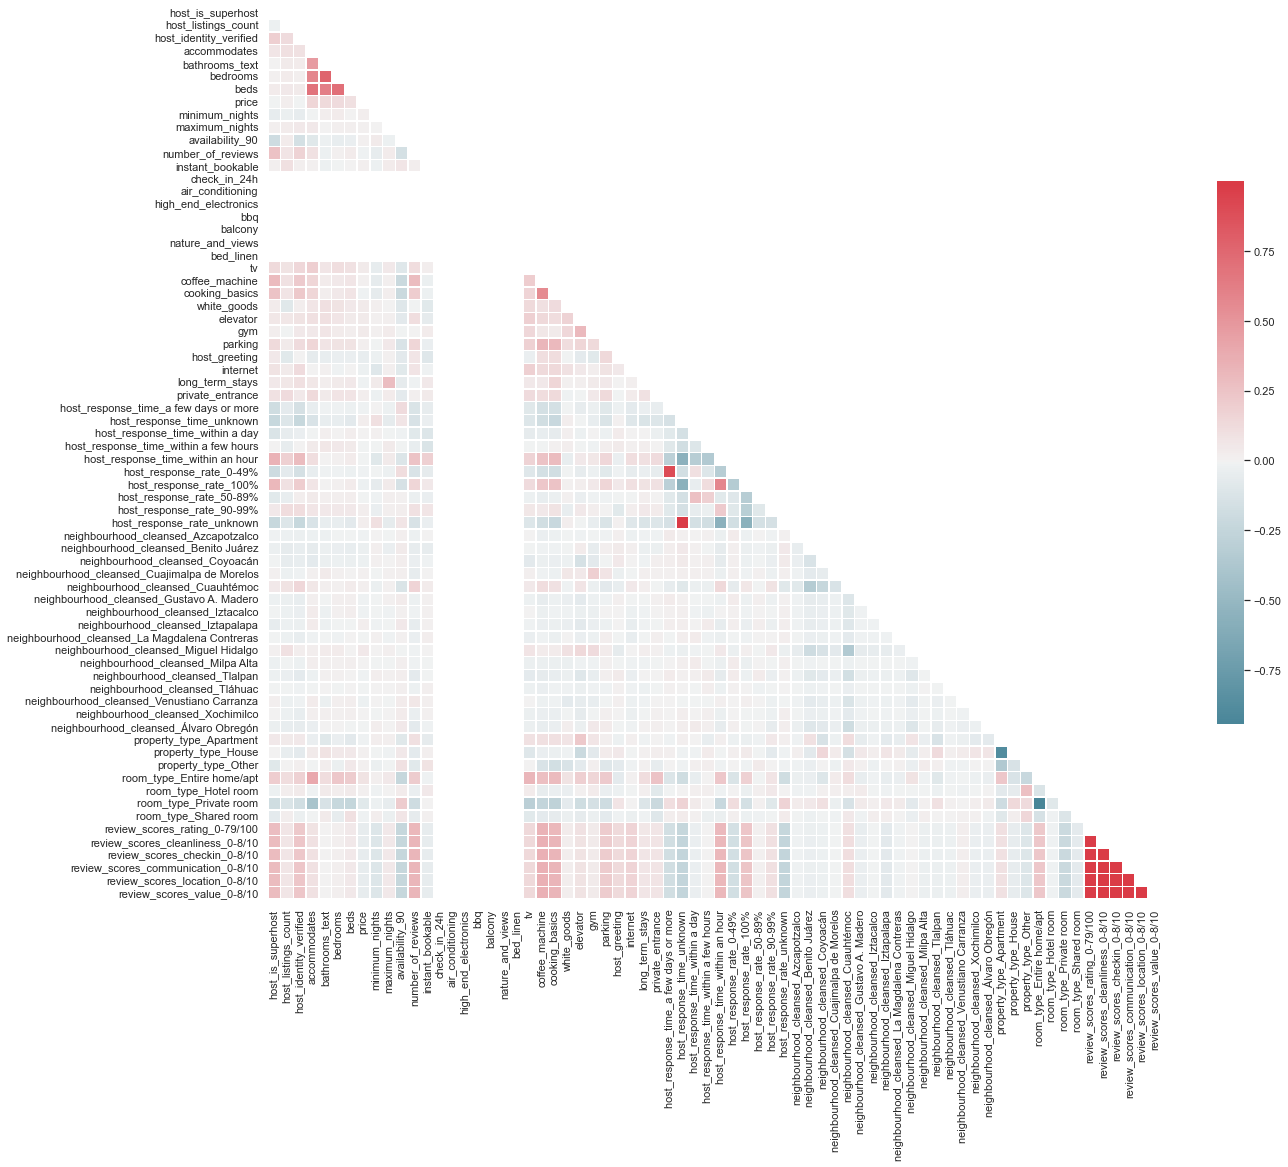

In [438]:
#Get multicolinearity of features
multi_collinearity_heatmap(dummy_df, figsize=(20,20))

In [439]:
# Separating X and y
X = dummy_df.drop('price', axis=1)
y = dummy_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

C:\Users\empha\anaconda3\envs\PythonData1\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\empha\anaconda3\envs\PythonData1\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


In [440]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [441]:
#XGB Regression
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

Time taken to run: 0.0 minutes

Training MSE: 978360.495
Validation MSE: 13466854.2622

Training r2: 0.9475
Validation r2: -0.9614


In [442]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)
ft_weights_xgb_reg.head(15)

,weight
parking,0.145924
room_type_Entire home/apt,0.120311
tv,0.092889
beds,0.047861
internet,0.041776
host_identity_verified,0.039741
neighbourhood_cleansed_Miguel Hidalgo,0.037886
bedrooms,0.030055
maximum_nights,0.030017
gym,0.029927


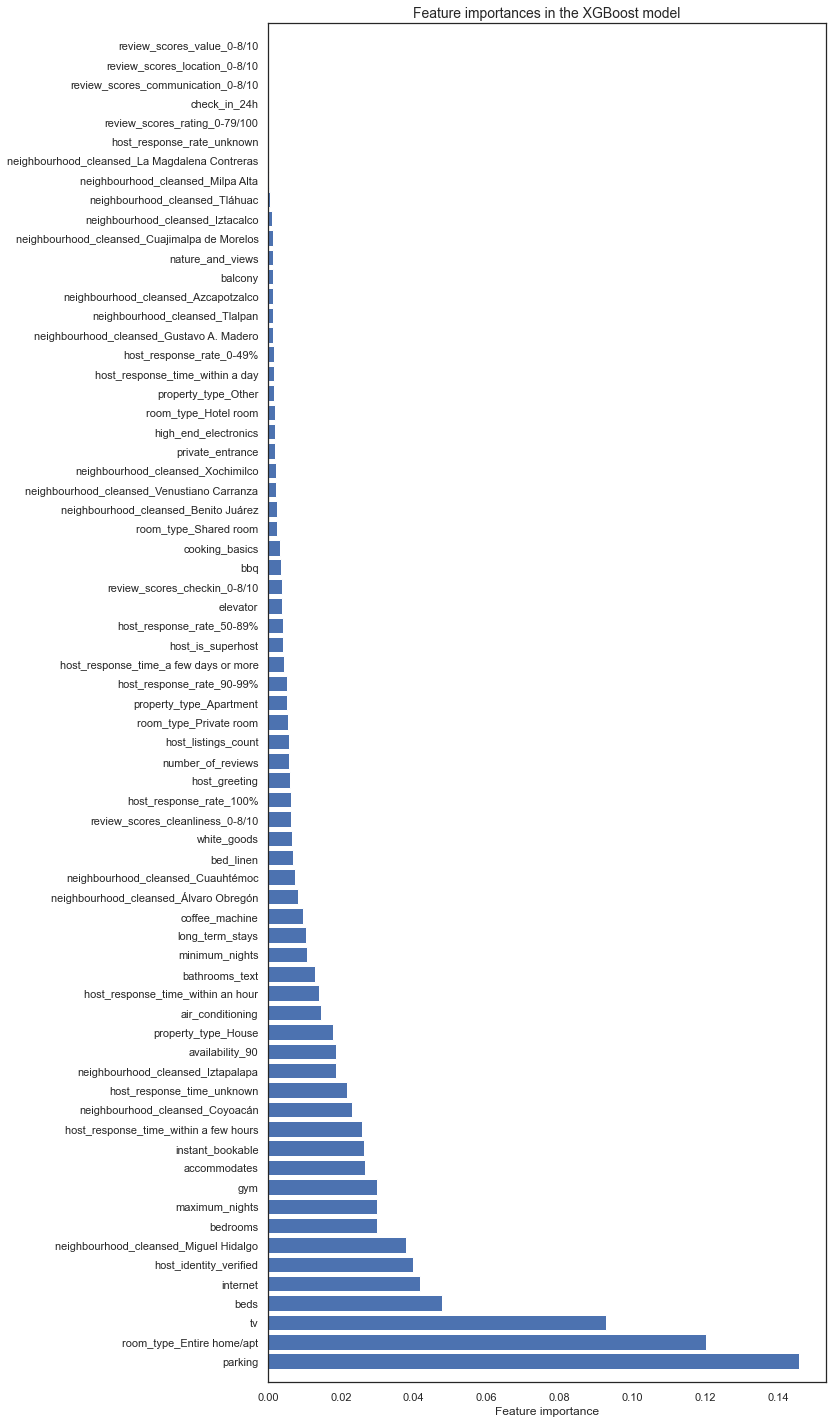

In [443]:
# Plotting feature importances
plt.figure(figsize=(10,25))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In [447]:
#Need to normalize our data
# Log transforming columns
numerical_columns = ['parking','tv','beds','bedrooms','internet','maximum_nights','gym','accommodates','air_conditioning'] # Removing items not to be transformed

In [450]:
#Most important ones are parking, type of home/apt, tv, beds, internet, host_identity_verified, bedrooms, maximum_nights,
#gym, accommodates, instan_bookable, host_response_time, availability, air conditioning, bathrooms, etc
knn = KNeighborsRegressor(algorithm='brute')
dummy_df = dummy_df.fillna(0)
knn.fit(dummy_df[numerical_columns], dummy_df['price'])
features_predictions = knn.predict(dummy_df[numerical_columns])
features_mse = mean_squared_error(dummy_df['price'], features_predictions)
features_rmse = features_mse ** (1/2)
features_rmse

4149.339108348347

In [456]:
features_predictions[8]

6097.4